# Лабораторная работа "Открытый оптический резонатор"

## В  настоящем блокноте представлена  программа для графического представления  полученны осциллограм в  случаях:
 ###              в режиме наилучшего согласования ООР и сканирующего интерферометра
###              в режиме умеренного согласования ООР и сканирующего интерферометра
###              в двухчастотномрежиме работы лазеры


In [91]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.signal import argrelextrema
from scipy.signal import find_peaks, peak_widths
from scipy.signal import savgol_filter
import copy
import math

In [92]:
# Пути для данных и сохранения результатов
data_path = r"C:\Users\Ruslan\Desktop\учеба\Лабы\Лабы 8 семестр\ООР\laboratory_work\open_optical_resonator\OOR_lab_data"
save_path = "results"


## Известные параметры

In [93]:
lamda = 632.8e-9  # длина волны лазера  
L_laser = 0.37    # длина резонатора лазера
c = 3e+8          # скорость света в вакууме 
R_interf = 1      # радиус кривизны сканирующего интерферометра 
L__interf = 0.05  # длина резонатора интерферометра

In [94]:
def unpack(path): 
    file = open(path, 'r' )
    data = file.readlines()
    data = [line.rstrip().split(",") for line in data]
    settings = data[:4]
    del data[:5]
    data = np.array(data).astype("float")
    return  settings, data

def unpack_two_ch(path, mode): 
    chanal = ["2","3"]
    source = ['gen' , "oor"]
    data = []
    for i in range(2):         
        file = open(path + "\\" + "Chanal_{}_{}_{}.txt".format(chanal[i], source[i], mode ), 'r' )
        signal = file.readlines()
        signal = [line.rstrip().split(",") for line in signal]
        if i == 0: 
            settings = signal[:4]
        del signal[:5]
        signal = np.array(signal).astype("float")
        data.append(signal)
    time = data[0][:,0]
    signal_oor = data[1][:,1]
    signal_gen = data[0][:,1]
    return  settings, time, signal_oor, signal_gen

def find_max(data, prominence, distance):
    max_ind = find_peaks(data[1],  prominence =  prominence, distance = distance)
    return [data[0][max_ind[0]],data[1][max_ind[0]], max_ind[0] ]

def calc_width(left_coords, right_coords, time_data):
         return time_data[right_coords] - time_data[left_coords]
    
def calc_arrow_params(left_half_max_ind, right_half_max_ind, half_level, left_steps, right_steps, time, arrow_head_part ):
    line_part = 1 - arrow_head_part
    left_arrow_start = time[left_half_max_ind - left_steps]  
    right_arrow_start = time[right_half_max_ind + right_steps] 
    left_arrow_length = (time[left_half_max_ind] - left_arrow_start) * line_part
    right_arrow_length = (
                            (right_arrow_start - time[right_half_max_ind]) - 
                            (arrow_head_part * (time[left_half_max_ind] - left_arrow_start))
                          )
    arrow_head_length = (time[left_half_max_ind] - left_arrow_start) * arrow_head_part
    tau_high = half_level.max() * 0.05 + half_level
    tau_time = time[right_half_max_ind + 80]
    res =   [
              left_arrow_start, 
              left_arrow_length,
              right_arrow_start,
              right_arrow_length, 
              time[left_half_max_ind],
              time[right_half_max_ind],
              arrow_head_length, 
              half_level, 
              tau_time,
              tau_high,
            ]
    return res

def calc_vlines_params(max_ind, time, max_level,  start=None):
    vlines_param = []
    peak = len(max_ind)
    for i in range(peak):
        if i == 0: 
            y_max = max([max_level[i], max_level[i + 1]]) + max_level.max() * 0.1
        elif i < peak - 2: 
            y_max = max([max_level[i - 1], max_level[i], max_level[i + 1]]) + max_level.max() * 0.1
        else:
            y_max = max([ max_level[-1], max_level[-2]]) + max_level.max() * 0.1
        if start is None:
            y_min = max_level[i]
        else:
            y_min = start
        time_coord = time[max_ind[i]]
        vlines_param.append([time_coord, y_min, y_max])
    return vlines_param
    
def calc_arrow_params_2(max_ind, time, max_level, arrow_head_procent, tau_step):
    arrow_params = []
    for i in range(len(max_ind ) - 1):
        arrow_high = max([max_level[i], max_level[i + 1]]) + max_level.max()  * 0.05
        arrow_center =(time[max_ind[i + 1]] + time[max_ind[i]]) / 2
        arrow_length =  (time[max_ind[i + 1]] - time[max_ind[i]]) * (arrow_head_procent - 1) / 2 
        arrow_head_length = (time[max_ind[i + 1]] - time[max_ind[i]]) * (arrow_head_procent) / 2 
        tau_time = time[max_ind[i]] + (arrow_center - time[max_ind[i]]) * tau_step 
        tau_high = max([max_level[i], max_level[i + 1]]) + max_level.max()   * 0.06
        arrow_params.append([arrow_center, arrow_high, arrow_length, arrow_head_length, tau_time, tau_high ])
    return arrow_params


def round_func(errors):
    r_errors = []
    for error in errors: 
        r_error = np.round(error, -int(math.floor(math.log10(abs(error)))))
        power = np.log10(abs(r_error))
        if r_error * 10**abs(power) == 1:
            r_error = round(error, 2-int(math.floor(math.log10(abs(error))))-1)
        r_errors.append(r_error)
    return r_errors
 

In [95]:
# указатели для импортирования данных 
mode = ["full_agreement", "moderate_agreement" "double_frequency"]

## Двухчастотный режим работы лазера 

Первой задачей является определение масштаба, ведь осциллограф дает зависимость сигнала от времени, а не  сигнала от частоты.
Чтобы правильно замерить разницу частот между соседними модами и область свободной дисперсии(ОСД) сканирующего интерферометра в случае режимов наилучшего и умеренного согласований, нам необходимо померить время между наибольшими пиками в двухчастотном режиме. Это время будет соответствовать ОСД резонатора ЛАЗЕРА ($\frac{c}{2 L_{laser}}$), а  эту величину мы  можем посчитать из данных, приведённых в условии.

In [96]:
AFD_laser = c / (2 * L_laser)
print(AFD_laser)

405405405.4054054


In [97]:
settings_dfreq, time_dfreq, signal_oor_dfreq, signal_gen_dfreq   = unpack_two_ch(data_path, "double_frequency_a")
time_dfreq = time_dfreq - time_dfreq[0]

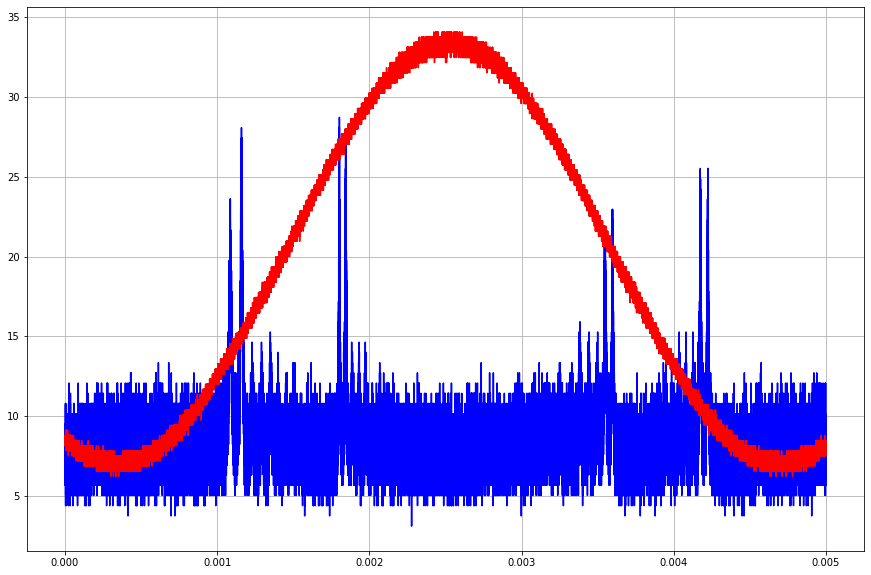

In [98]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(time_dfreq, signal_oor_dfreq*1000, c = 'blue') 
ax.plot(time_dfreq, signal_gen_dfreq+20, c = 'r')
ax.grid()

Отфильруем данные

In [99]:
signal_oor_dfreq_filtred = savgol_filter(signal_oor_dfreq, 99, 3)
signal_gen_dfreq_filtred = savgol_filter(signal_gen_dfreq, 99, 3)

In [100]:
time_coef = 1e+3
ampl_coef = 1e+3

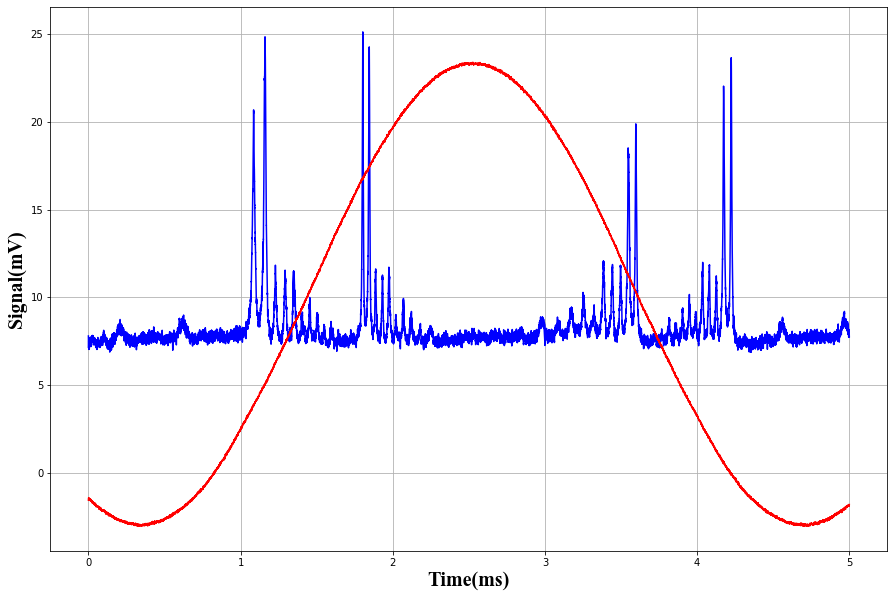

In [101]:
#общий график
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(time_dfreq * time_coef, signal_oor_dfreq_filtred*ampl_coef, c = 'blue') 
ax.plot(time_dfreq * time_coef, signal_gen_dfreq_filtred + 10, c = 'r')
ax.grid()
ax.set_xlabel('Time(ms)',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=20)
ax.set_ylabel("Signal(mV)",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=20)
plt.savefig(save_path + "\\" + "full_graph_of_doble_freq_generation.jpg")

Из оценочного графика видно, какой интервал подходит для определения ОCД резонатора лазера лучше всего [44000:47000](не относится к оси абсцисс, просто номера точек)



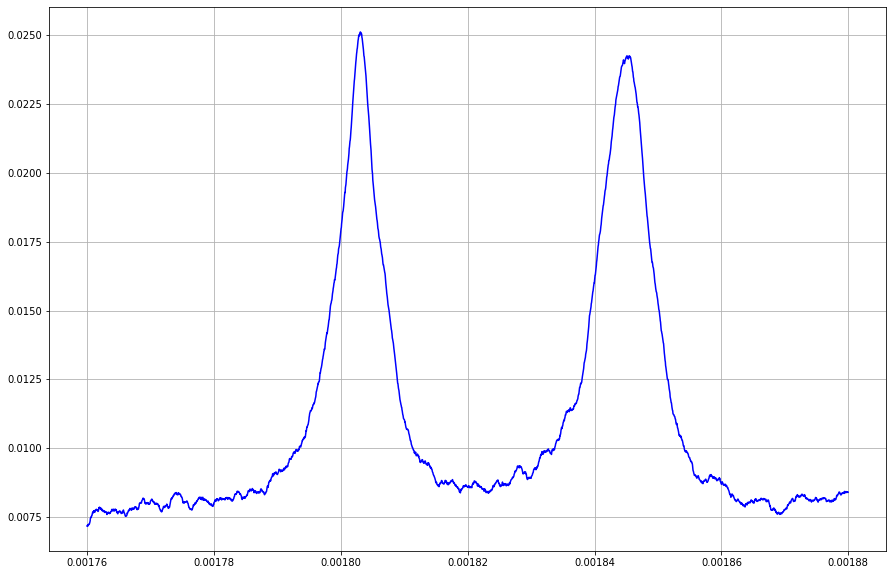

In [102]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(time_dfreq[44000:47000], signal_oor_dfreq_filtred[44000:47000], c = 'blue') 
ax.grid()

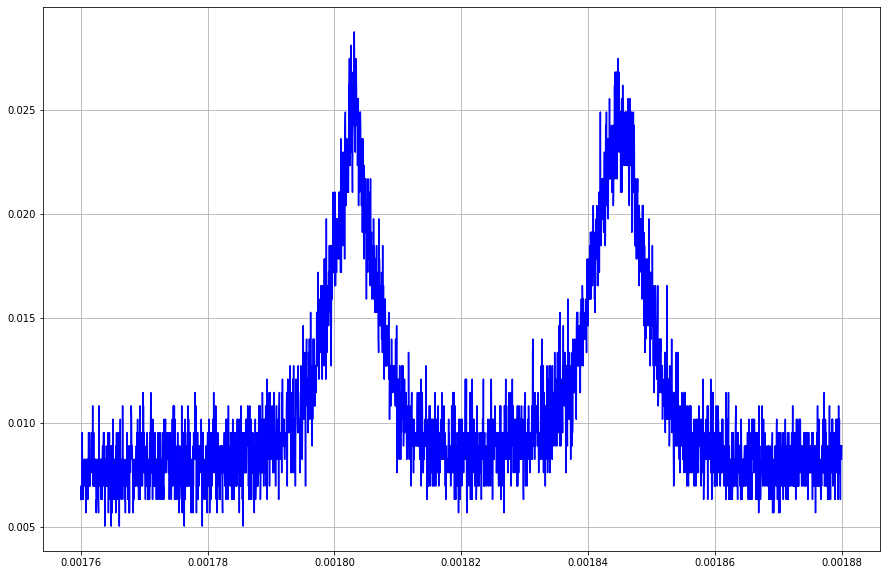

In [103]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(time_dfreq[44000:47000], signal_oor_dfreq[44000:47000], c = 'blue') 
ax.grid()

In [104]:
#переобозначим интересующую на зону
time_dfreq_crop = copy.copy(time_dfreq[44000:47000])
signal_oor_dfreq_crop = copy.copy(signal_oor_dfreq[44000:47000]) 
signal_oor_dfreq_filtred_crop = copy.copy(signal_oor_dfreq_filtred[44000:47000])
# сдвинем время на 0 и сигнал 
signal_oor_dfreq_crop = signal_oor_dfreq_crop - signal_oor_dfreq_crop.min()
signal_oor_dfreq_filtred_crop = signal_oor_dfreq_filtred_crop - signal_oor_dfreq_filtred_crop.min()
time_dfreq_crop = time_dfreq_crop - time_dfreq_crop[0]

In [105]:
max_time_dfreq_filtred_crop, max_signal_oor_dfreq_filtred_crop, max_ind_dfreq_filtred_crop = find_max([time_dfreq_crop,
                                                                                                       signal_oor_dfreq_filtred_crop
                                                                                                      ], 
                                                                                                      prominence = 0.01,
                                                                                                      distance = 500
                                                                                                         )

вычислим время, отвечающее ОСД

In [106]:
AFD_laser_time = max_time_dfreq_filtred_crop[1] - max_time_dfreq_filtred_crop[0]
print(AFD_laser_time)

4.204000000000013e-05


Теперь определим коэффициент пересчета времени в частоту для того, чтобы определить частоту между соседними модами и ОСД сканирующего интерферометра в случае режимов наилучшего и умеренного согласований. 
Тогда выражение для разности частот примет вид: $ \Delta\nu = \Delta t  * \alpha = \frac{\Delta t  * c }{2 L_{laser} * \tau_{dfreq}}$ 

In [107]:
alpha = AFD_laser / AFD_laser_time
print(alpha)

9643325532954.428


Оформим график  для отчета. Далее AFD_laser_time = $\Delta \tau$ на графике

In [108]:
#расчёт точек
time_coef = 1e+6
ampl_coef = 1e+3
line_width = 0.2*1e-3
max_line_width = max_signal_oor_dfreq_filtred_crop.max() * 1.1
arrow_centre = (max_time_dfreq_filtred_crop[1] + max_time_dfreq_filtred_crop[0]) / 2
arrow_high  =  max_signal_oor_dfreq_filtred_crop.max() * 1.05
arrow_length = (max_time_dfreq_filtred_crop[1] - max_time_dfreq_filtred_crop[0]) * 0.9 / 2 
arrow_head_width = line_width
arrow_head_length = (max_time_dfreq_filtred_crop[1] - max_time_dfreq_filtred_crop[0]) * 0.1 / 2 
tau_centre = (arrow_centre - (arrow_length + arrow_head_length)) * 1.35 
tau_high = arrow_high * 1.015


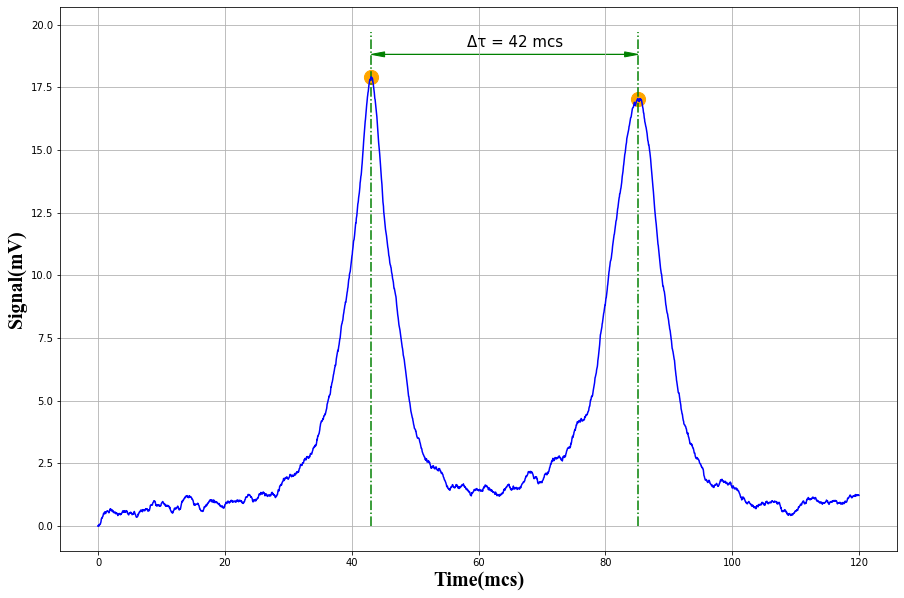

In [109]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(time_dfreq_crop * time_coef , signal_oor_dfreq_filtred_crop * ampl_coef , c = 'blue') 
ax.set_xlabel('Time(mcs)',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=20)
ax.set_ylabel("Signal(mV)",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=20)
ax.text(tau_centre * time_coef, tau_high * ampl_coef, "Δτ = 42 mcs",fontsize = 15)
ax.scatter(
            time_dfreq_crop[max_ind_dfreq_filtred_crop[0]] * time_coef,
            signal_oor_dfreq_filtred_crop[max_ind_dfreq_filtred_crop[0]] * ampl_coef,
            color="orange", s=200, marker='o' 
            )
ax.scatter(
            time_dfreq_crop[max_ind_dfreq_filtred_crop[1]] * time_coef,
            signal_oor_dfreq_filtred_crop[max_ind_dfreq_filtred_crop[1]] * ampl_coef,
            color="orange", s=200, marker='o' 
            )
ax.vlines(
            time_dfreq_crop[max_ind_dfreq_filtred_crop[0]]* time_coef,
            ymin = 0, ymax = max_line_width * ampl_coef, color = 'green',linestyles = 'dashdot'
            )
ax.vlines(
          time_dfreq_crop[max_ind_dfreq_filtred_crop[1]]* time_coef,
          ymin = 0, ymax = max_line_width * ampl_coef, color = 'green',linestyles = 'dashdot'
            )
ax.arrow(
         arrow_centre * time_coef, arrow_high * ampl_coef, -arrow_length  * time_coef, 0,
         head_width=arrow_head_width * ampl_coef, head_length=arrow_head_length * time_coef, color = 'g'
        )
ax.arrow(
          arrow_centre * time_coef, arrow_high * ampl_coef, arrow_length  * time_coef, 0,
          head_width=arrow_head_width* ampl_coef, head_length=arrow_head_length *time_coef , color = 'g'
        )
ax.grid()
plt.savefig(save_path + "\\" + "peacks_of_doble_freq_generation.jpg")


Когда коэффициент получен, можно определить все, что требуется по заданию 

## Режим наилучшего согласования ООР и сканирующего интерферометра

In [110]:
settings_full_agr, time_full_agr, signal_oor_full_agr, signal_gen_full_agr  = unpack_two_ch(data_path, "full_agreement")
# сдвинем для удобства время на 0
time_full_agr = time_full_agr - time_full_agr[0]

Отфильтруем сигнал

In [111]:
signal_oor_full_agr_filtred = savgol_filter(signal_oor_full_agr, 99, 3)
signal_gen_full_agr_filtred = savgol_filter(signal_gen_full_agr, 99, 3)

Находим  зону  информативного сигнала на первичном графике
Видно, что зона с индексами [24000:50000] вполне подходит

In [112]:
time_coef = 1e+3
ampl_coef = 1e+3

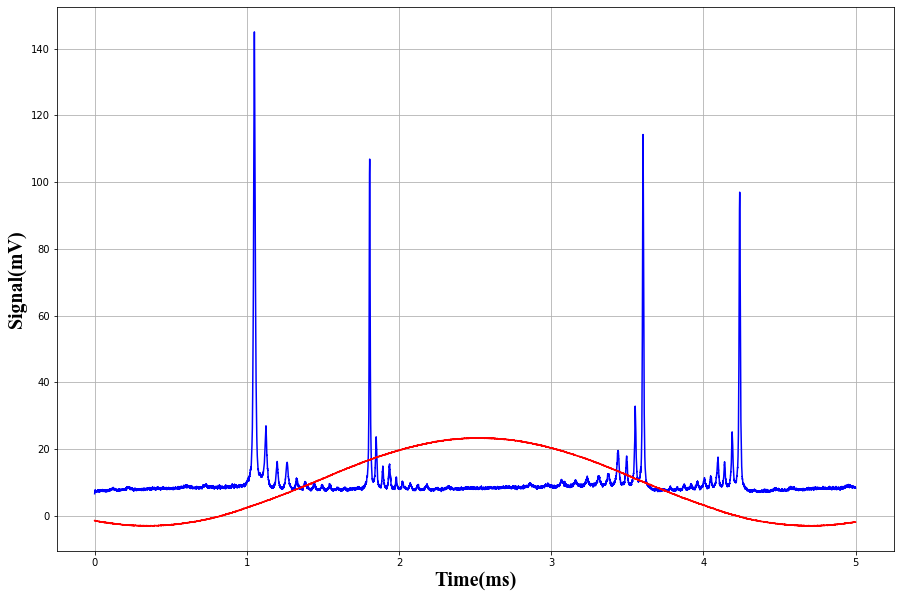

In [113]:
# первичный график
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(time_full_agr*time_coef, signal_oor_full_agr_filtred * ampl_coef, c = 'blue') 
ax.plot(time_full_agr*time_coef, signal_gen_full_agr_filtred + 10, c = 'red') 
ax.grid()
ax.set_xlabel('Time(ms)',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=20)
ax.set_ylabel("Signal(mV)",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=20)
plt.savefig(save_path + "\\" + "full_graph_of_full_agr_generation.jpg")

 Найдем расстояние между соседними поперечными модами 


In [114]:
time_full_agr_crop = copy.copy(time_full_agr[24000:50000])
time_full_agr_crop = time_full_agr_crop - time_full_agr_crop[0]
signal_oor_full_agr_filtred_crop = copy.copy(signal_oor_full_agr_filtred[24000:50000]) 
signal_oor_full_agr_filtred_crop = signal_oor_full_agr_filtred_crop - signal_oor_full_agr_filtred_crop.min()

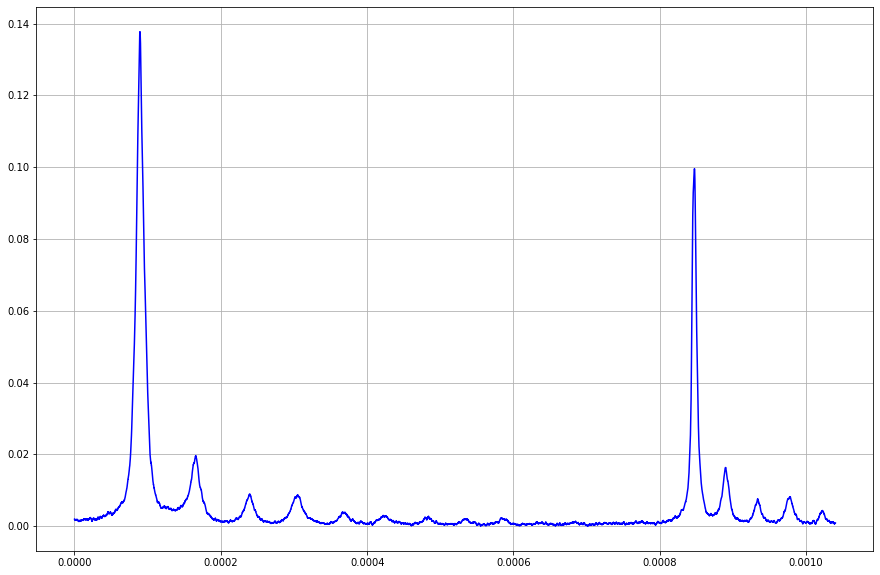

In [115]:
# первичный графи
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(time_full_agr_crop, signal_oor_full_agr_filtred_crop, c = 'blue') 
ax.grid()

Найдём максимумы

In [116]:
max_time_full_agr_filtred_crop, max_signal_oor_full_agr_filtred_crop, max_ind_full_agr_filtred_crop = find_max([time_full_agr_crop, signal_oor_full_agr_filtred_crop], 
                                                                                                                  prominence = 0.005,
                                                                                                                  distance = 500
                                                                                                                 )

Найдем ширины пиков

In [117]:
_, half_level_full_agr_crop, left_coord_indx_full_agr_crop, right_coord_indx_full_agr_crop = peak_widths(
                                                                                                            signal_oor_full_agr_filtred_crop, 
                                                                                                            max_ind_full_agr_filtred_crop, 
                                                                                                            rel_height=0.5 
                                                                                                            )

left_coord_indx_full_agr_crop = np.round(left_coord_indx_full_agr_crop).astype('int')
right_coord_indx_full_agr_crop = np.round(right_coord_indx_full_agr_crop).astype('int')


### Вычислим:
а) частотные интервалы между соседними
поперечными модами интерферометра;<br>
б) ширины резонансов для низших и высших
типов колебаний интерферометра

In [118]:
# частотные интервалы между соседними поперечными модами интерферометра
freq_interval_full_agr = np.diff(max_time_full_agr_filtred_crop) * alpha
tau_freq_interval_full_agr = np.diff(max_time_full_agr_filtred_crop)
freq_interval_full_agr = np.delete(freq_interval_full_agr, 3)
tau_freq_interval_full_agr = np.delete(tau_freq_interval_full_agr, 3)

In [119]:
# ширины резонансов для низших и высших типов колебаний интерферометра
peak_width_full_agr_crop = calc_width(left_coord_indx_full_agr_crop, right_coord_indx_full_agr_crop, time_full_agr_crop) * alpha
peak_width_full_agr_crop = calc_width(left_coord_indx_full_agr_crop, right_coord_indx_full_agr_crop, time_full_agr_crop)

In [120]:
# Область свободной дисперсии
AFD_full_agr = max_time_full_agr_filtred_crop[4] - max_time_full_agr_filtred_crop[0] 
print(AFD_full_agr)

0.0007578400000000001


### Нарисуем Графики 

In [121]:
time_coef = 1e+6
ampl_coef = 1e+3
line_width = 1e-3
max_line_width = max_signal_oor_full_agr_filtred_crop.max() * 1.1
arrow_centre = (max_time_full_agr_filtred_crop[4] + max_time_full_agr_filtred_crop[0]) / 2
arrow_high  =  max_signal_oor_full_agr_filtred_crop.max() * 1.05
arrow_length = (max_time_full_agr_filtred_crop[4] - max_time_full_agr_filtred_crop[0]) * 0.9 / 2 
arrow_head_width = line_width
arrow_head_length = (max_time_full_agr_filtred_crop[4] - max_time_full_agr_filtred_crop[0]) * 0.1 / 2 
tau_centre = (arrow_centre - (arrow_length + arrow_head_length)) * 4.35 
tau_high = arrow_high * 1.015

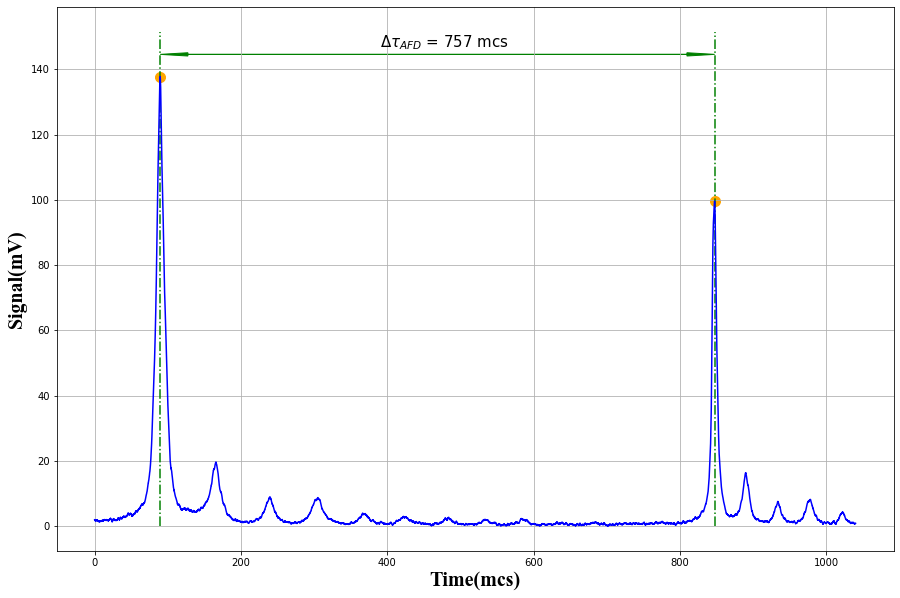

In [122]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(time_full_agr_crop * time_coef, signal_oor_full_agr_filtred_crop * ampl_coef , c = 'blue') 
ax.set_xlabel('Time(mcs)',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=20)
ax.set_ylabel("Signal(mV)",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=20)
ax.text(tau_centre * time_coef, tau_high * ampl_coef, "$Δτ_{AFD}$ = 757 mcs",fontsize = 15)
ax.scatter(
            time_full_agr_crop[max_ind_full_agr_filtred_crop[0]] * time_coef,
            signal_oor_full_agr_filtred_crop[max_ind_full_agr_filtred_crop[0]] * ampl_coef,
            color="orange", s=100, marker='o' 
            )
ax.scatter(
            time_full_agr_crop[max_ind_full_agr_filtred_crop[4]] * time_coef,
            signal_oor_full_agr_filtred_crop[max_ind_full_agr_filtred_crop[4]] * ampl_coef,
            color="orange", s=100, marker='o' 
            )
ax.vlines(
            time_full_agr_crop[max_ind_full_agr_filtred_crop[0]]* time_coef,
            ymin = 0, ymax = max_line_width * ampl_coef, color = 'green',linestyles = 'dashdot'
            )
ax.vlines(
          time_full_agr_crop[max_ind_full_agr_filtred_crop[4]]* time_coef,
          ymin = 0, ymax = max_line_width * ampl_coef, color = 'green',linestyles = 'dashdot'
            )
ax.arrow(
         arrow_centre * time_coef, arrow_high * ampl_coef, -arrow_length  * time_coef, 0,
         head_width=arrow_head_width * ampl_coef, head_length=arrow_head_length * time_coef, color = 'g'
        )
ax.arrow(
          arrow_centre * time_coef, arrow_high * ampl_coef, arrow_length  * time_coef, 0,
          head_width=arrow_head_width* ampl_coef, head_length=arrow_head_length *time_coef , color = 'g'
        )
ax.grid()
plt.savefig(save_path + "\\" + "full_agr_AFD.jpg")

Нарисуем более детально 

In [123]:
time_coef = 1e+6
l_range = 0
r_range = 10000
ampl_coef = 1e+3
line_width = 1e-3
arrow_head_width = line_width
arrow_params = calc_arrow_params(
                                 left_coord_indx_full_agr_crop[:4], 
                                 right_coord_indx_full_agr_crop[:4],
                                 half_level_full_agr_crop[:4],
                                 300, 
                                 800, 
                                 time_full_agr_crop[l_range:r_range],
                                 0.5
                                )
arrow_params_2 = calc_arrow_params_2(max_ind=max_ind_full_agr_filtred_crop[:4] ,
                                     time=time_full_agr_crop, 
                                     max_level=max_signal_oor_full_agr_filtred_crop[:4], 
                                     arrow_head_procent=0.1, 
                                     tau_step = 0.7
                                     )

vlines_params = calc_vlines_params(max_ind=max_ind_full_agr_filtred_crop[:4] ,
                                   time=time_full_agr_crop,
                                   max_level=max_signal_oor_full_agr_filtred_crop[:4],
                                   start=0)


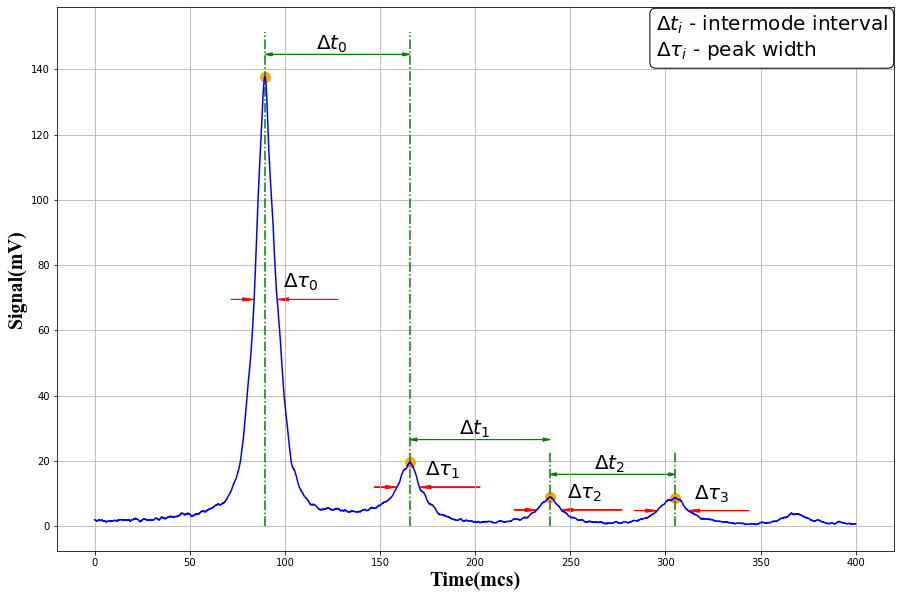

In [124]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(
        time_full_agr_crop[l_range:r_range] * time_coef, 
        signal_oor_full_agr_filtred_crop[l_range:r_range] * ampl_coef , c = 'blue'
        ) 
box = {'facecolor':'white',    
       'edgecolor': 'black',     
       'boxstyle': 'round'}

ax.text(295, 144, ('$Δt_{i}$ - intermode interval\n$Δτ_{i}$ - peak width '),
        bbox = box,
        color = 'black',    
        fontsize = 20)


for i in range(4):
    ax.arrow(
             arrow_params[0][i] * time_coef,  arrow_params[7][i] * ampl_coef, + arrow_params[1][i] * time_coef, 0,
             head_width=arrow_head_width * ampl_coef, head_length=arrow_params[6][i] * time_coef, color = 'r'
            )
    ax.arrow(
             arrow_params[2][i] * time_coef,  arrow_params[7][i] * ampl_coef, -arrow_params[3][i] * time_coef, 0,
             head_width=arrow_head_width * ampl_coef, head_length=arrow_params[6][i] * time_coef, color = 'r'
            )
#     ax.hlines(
#             arrow_params[7][i] * ampl_coef, xmin = arrow_params[4][i] * time_coef, 
#             xmax = arrow_params[5][i] * time_coef, color = 'green'
#             )
    const = str(
                round((time_full_agr_crop[right_coord_indx_full_agr_crop[i]] - 
                time_full_agr_crop[left_coord_indx_full_agr_crop[i]] )* time_coef)
                )
    ax.scatter(
            time_full_agr_crop[max_ind_full_agr_filtred_crop[i]] * time_coef,
            signal_oor_full_agr_filtred_crop[max_ind_full_agr_filtred_crop[i]] * ampl_coef,
            color='orange', s=100, marker='o' 
            )
    
    ax.vlines(vlines_params[i][0] * time_coef, ymin = vlines_params[i][1] * ampl_coef, 
            ymax = vlines_params[i][2] * ampl_coef, color = 'green', linestyles = 'dashdot'
            )
    ax.text(arrow_params[8][i] * time_coef, arrow_params[9][i] * ampl_coef, "$Δτ_{0}$".format(str(i)), fontsize = 20)
for i in range(3):
    ax.arrow(
             arrow_params_2[i][0] * time_coef,  arrow_params_2[i][1] * ampl_coef, + arrow_params_2[i][2] * time_coef, 0,
             head_width=arrow_head_width * ampl_coef, head_length=arrow_params_2[i][3] * time_coef, color = 'g'
            )
    ax.arrow(
             arrow_params_2[i][0] * time_coef,  arrow_params_2[i][1] * ampl_coef, -arrow_params_2[i][2] * time_coef, 0,
             head_width=arrow_head_width * ampl_coef, head_length=arrow_params_2[i][3] * time_coef, color = 'g'
            )
    
    ax.text(arrow_params_2[i][4] * time_coef, arrow_params_2[i][5] * ampl_coef, "$Δt_{0}$".format(str(i)), fontsize = 20)
ax.grid()
ax.set_xlabel('Time(mcs)',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=20)
ax.set_ylabel("Signal(mV)",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=20)
plt.savefig(save_path + "\\" + "full_agr_widths.jpg")


## Режим умеренного рассогласования ООР и сканирующего интерферометра

In [125]:
settings_mod_agr, time_mod_agr, signal_oor_mod_agr, signal_gen_mod_agr  = unpack_two_ch(data_path, "moderate_agreement_a")
# сдвинем для удобства время на 0
time_mod_agr = time_mod_agr - time_mod_agr[0]

Отфильтруем сигнал


In [126]:
signal_oor_mod_agr = savgol_filter(signal_oor_mod_agr, 99, 3)
signal_gen_mod_agr = savgol_filter(signal_gen_mod_agr, 99, 3)

In [127]:
time_coef = 1e+3
ampl_coef = 1e+3

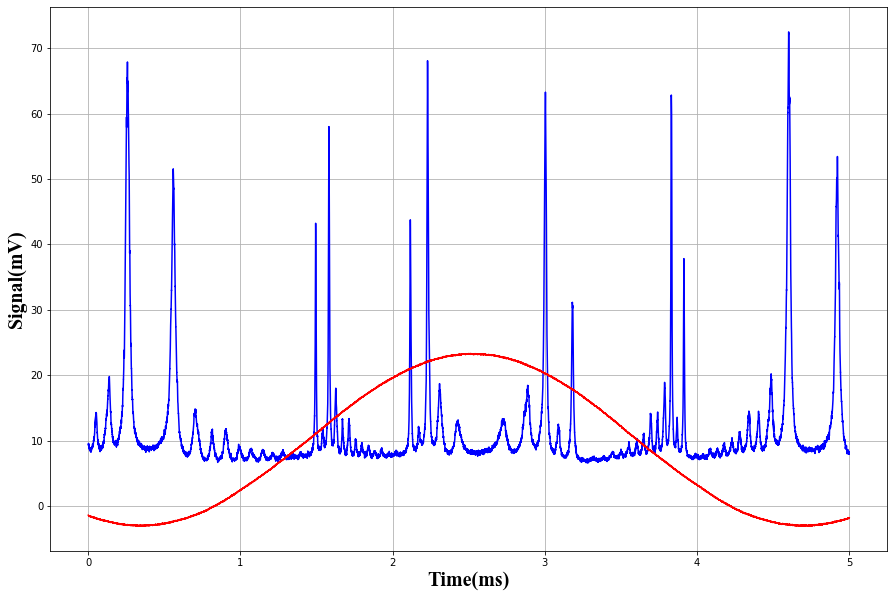

In [128]:
# первичный график всего сигнала
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)

ax.plot(time_mod_agr * time_coef, signal_oor_mod_agr*1000, c = 'blue') 
ax.plot(time_mod_agr * time_coef, signal_gen_mod_agr+10, c = 'r')
ax.grid()
ax.set_xlabel('Time(ms)',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=20)
ax.set_ylabel("Signal(mV)",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=20)
plt.savefig(save_path + "\\" + "full_graph_of_mod_agr_generation.jpg")

Находим  зону  информативного сигнала на первичном графике
Видно, что зона с индексами [35000:63000] вполне подходит

In [129]:
#Сдвинем для удобства
signal_oor_mod_agr_filtred_crop = copy.copy(signal_oor_mod_agr[35000:63000])
time_mod_agr_crop = copy.copy(time_mod_agr[35000:63000])
time_mod_agr_crop = time_mod_agr_crop - time_mod_agr_crop[0]
signal_oor_mod_agr_filtred_crop = signal_oor_mod_agr_filtred_crop - signal_oor_mod_agr_filtred_crop.min()

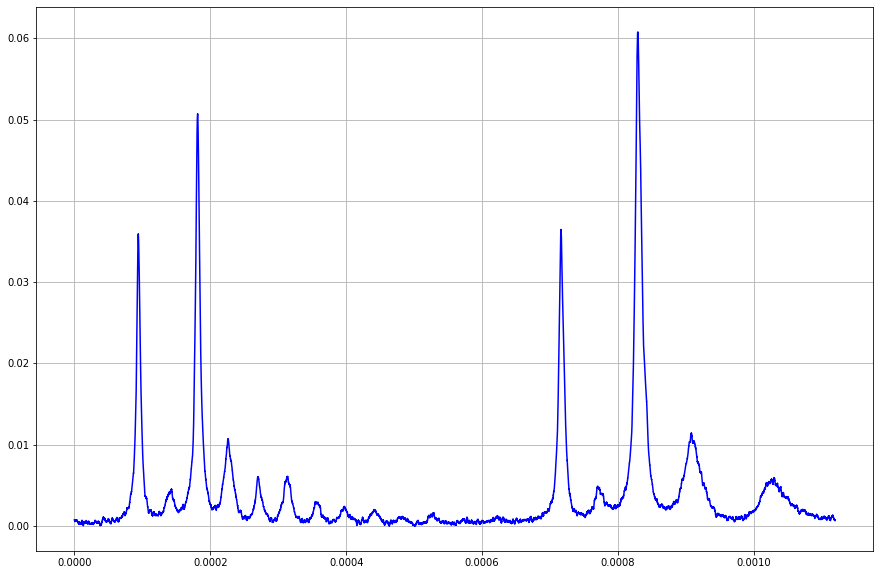

In [130]:
#первичный график
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(time_mod_agr_crop, signal_oor_mod_agr_filtred_crop, c = 'blue') 
ax.grid()

In [131]:
max_time_mod_agr_filtred_crop, max_signal_oor_mod_agr_filtred_crop, max_ind_mod_agr_filtred_crop = find_max([time_mod_agr_crop, signal_oor_mod_agr_filtred_crop], 
                                                                                                                  prominence = 0.002,
                                                                                                                  distance = 300
                                                                                                                 )

In [132]:
#удалим ненужные пики
max_time_mod_agr_filtred_crop = np.delete(max_time_mod_agr_filtred_crop, [6,7])
max_signal_oor_mod_agr_filtred_crop = np.delete(max_signal_oor_mod_agr_filtred_crop, [6,7])
max_ind_mod_agr_filtred_crop = np.delete(max_ind_mod_agr_filtred_crop, [6,7])

Информация о максимумах 

In [133]:
_, half_level_mod_agr_crop, left_coord_indx_mod_agr_crop, right_coord_indx_mod_agr_crop = peak_widths(
                                                                                                        signal_oor_mod_agr_filtred_crop, 
                                                                                                        max_ind_mod_agr_filtred_crop, 
                                                                                                        rel_height=0.5 
                                                                                                        )

left_coord_indx_mod_agr_crop = np.round(left_coord_indx_mod_agr_crop).astype('int')
right_coord_indx_mod_agr_crop = np.round(right_coord_indx_mod_agr_crop).astype('int')

### Вычислим:
а) частотные интервалы между соседними
поперечными модами интерферометра;<br>
б) ширины резонансов для низших и высших
типов колебаний интерферометра

In [134]:
# частотные интервалы между соседними поперечными модами интерферометра
freq_interval_mod_agr = np.diff(max_time_mod_agr_filtred_crop) * alpha
tau_freq_interval_mod_agr = np.diff(max_time_mod_agr_filtred_crop)
freq_interval_mod_agr = np.delete(freq_interval_mod_agr, 5)
tau_freq_interval_mod_agr = np.delete(tau_freq_interval_mod_agr,5)


In [135]:
# ширины резонансов для низших и высших типов колебаний интерферометра
peak_width_mod_agr_crop = calc_width(left_coord_indx_mod_agr_crop, right_coord_indx_mod_agr_crop, time_mod_agr_crop) * alpha
print(peak_width_mod_agr_crop)

[6.09458174e+07 1.14948440e+08 7.29035410e+07 1.21891635e+08
 8.75613958e+07 1.14948440e+08 8.17754005e+07 1.11091110e+08
 1.08005246e+08 2.14467560e+08 4.05019962e+08]


In [136]:
# Область свободной дисперсии
AFD_mod_agr = max_time_mod_agr_filtred_crop[6] - max_time_mod_agr_filtred_crop[0]
AFD_mod_agr * 1e+6 

622.0800000000002

### Нарисуем Графики 

In [137]:
time_coef = 1e+6
ampl_coef = 1e+3
line_width = 1e-3
max_line_length = np.sort(max_signal_oor_mod_agr_filtred_crop)[-2] * 1.15
arrow_centre = (max_time_mod_agr_filtred_crop[6] + max_time_mod_agr_filtred_crop[0]) / 2
arrow_high  =  np.sort(max_signal_oor_mod_agr_filtred_crop)[-2] * 1.05
arrow_length = (max_time_mod_agr_filtred_crop[6] - max_time_mod_agr_filtred_crop[0]) * 0.9 / 2 
arrow_head_width = line_width
arrow_head_length = (max_time_mod_agr_filtred_crop[6] - max_time_mod_agr_filtred_crop[0]) * 0.1 / 2 
tau_centre = (arrow_centre - (arrow_length + arrow_head_length)) * 3.5
tau_high = arrow_high * 1.015

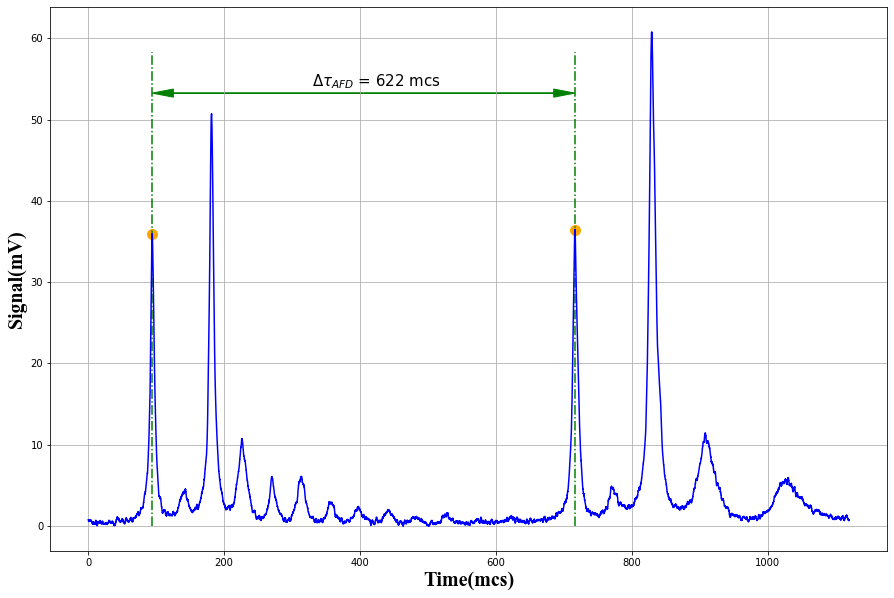

In [138]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(time_mod_agr_crop * time_coef, signal_oor_mod_agr_filtred_crop * ampl_coef , c = 'blue') 
ax.set_xlabel('Time(mcs)',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=20)
ax.set_ylabel("Signal(mV)",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=20)
ax.text(tau_centre * time_coef, tau_high * ampl_coef, "$Δτ_{AFD}$ = 622 mcs",fontsize = 15)
ax.scatter(
            time_mod_agr_crop[max_ind_mod_agr_filtred_crop[0]] * time_coef,
            signal_oor_mod_agr_filtred_crop[max_ind_mod_agr_filtred_crop[0]] * ampl_coef,
            color='orange', s=100, marker='o' 
            )
ax.scatter(
            time_mod_agr_crop[max_ind_mod_agr_filtred_crop[6]] * time_coef,
            signal_oor_mod_agr_filtred_crop[max_ind_mod_agr_filtred_crop[6]] * ampl_coef,
            color='orange', s=100, marker='o' 
            )
ax.vlines(
            time_mod_agr_crop[max_ind_mod_agr_filtred_crop[0]]* time_coef,
            ymin = 0, ymax = max_line_length * ampl_coef, color = 'green',linestyles = 'dashdot'
            )
ax.vlines(
          time_mod_agr_crop[max_ind_mod_agr_filtred_crop[6]]* time_coef,
          ymin = 0, ymax = max_line_length * ampl_coef, color = 'green',linestyles = 'dashdot'
            )
ax.arrow(
         arrow_centre * time_coef, arrow_high * ampl_coef, -arrow_length  * time_coef, 0,
         head_width=arrow_head_width * ampl_coef, head_length=arrow_head_length * time_coef, color = 'g'
        )
ax.arrow(
          arrow_centre * time_coef, arrow_high * ampl_coef, arrow_length  * time_coef, 0,
          head_width=arrow_head_width* ampl_coef, head_length=arrow_head_length *time_coef , color = 'g'
        )
ax.grid()
plt.savefig(save_path + "\\" + "mod_agr_AFD.jpg")

In [139]:
time_coef = 1e+6
l_range = 0
r_range = 9000
ampl_coef = 1e+3
line_width = 0.5*1e-3
arrow_head_width = line_width
arrow_params = calc_arrow_params(
                                 left_coord_indx_mod_agr_crop[:6], 
                                 right_coord_indx_mod_agr_crop[:6],
                                 half_level_mod_agr_crop[:6],
                                 300, 
                                 800, 
                                 time_mod_agr_crop[l_range:r_range],
                                 0.4
                                )
arrow_params_2 = calc_arrow_params_2(max_ind=max_ind_mod_agr_filtred_crop[:6] ,
                                     time=time_mod_agr_crop, 
                                     max_level=max_signal_oor_mod_agr_filtred_crop[:6], 
                                     arrow_head_procent=0.2, 
                                     tau_step = 0.7
                                     )

vlines_params = calc_vlines_params(max_ind=max_ind_mod_agr_filtred_crop[:6] ,
                                   time=time_mod_agr_crop,
                                   max_level=max_signal_oor_mod_agr_filtred_crop[:6],
                                   start=0)


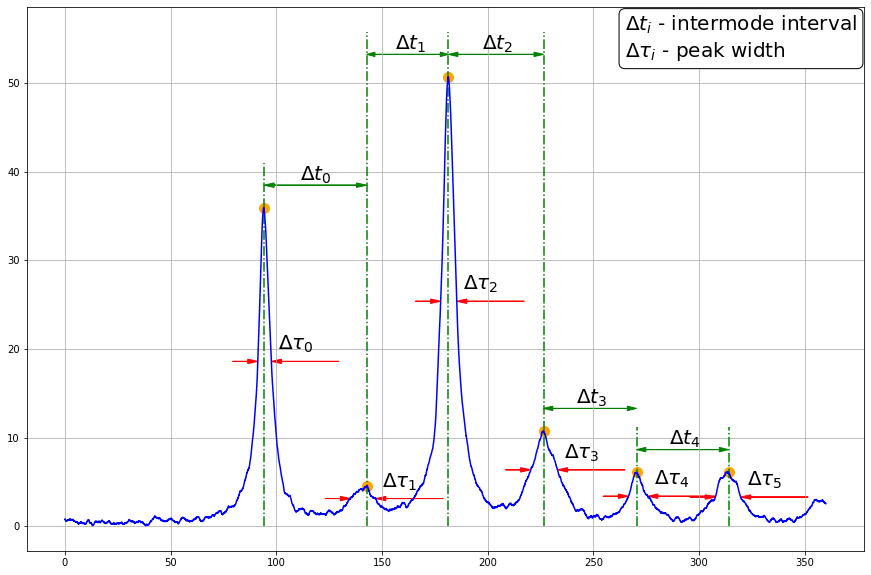

In [140]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(
        time_mod_agr_crop[l_range:r_range] * time_coef, 
        signal_oor_mod_agr_filtred_crop[l_range:r_range] * ampl_coef , c = 'blue'
        ) 

box = {'facecolor':'white',    
       'edgecolor': 'black',     
       'boxstyle': 'round'}

ax.text(265, 53, ('$Δt_{i}$ - intermode interval\n$Δτ_{i}$ - peak width '),
        bbox = box,
        color = 'black',    
        fontsize = 20)

for i in range(6):
    ax.arrow(
             arrow_params[0][i] * time_coef,  arrow_params[7][i] * ampl_coef, + arrow_params[1][i] * time_coef, 0,
             head_width=arrow_head_width * ampl_coef, head_length=arrow_params[6][i] * time_coef, color = 'r'
            )
    ax.arrow(
             arrow_params[2][i] * time_coef,  arrow_params[7][i] * ampl_coef, -arrow_params[3][i] * time_coef, 0,
             head_width=arrow_head_width * ampl_coef, head_length=arrow_params[6][i] * time_coef, color = 'r'
            )
    ax.scatter(
            max_time_mod_agr_filtred_crop[i] * time_coef,  max_signal_oor_mod_agr_filtred_crop[i] * ampl_coef,
            color='orange', s=100, marker='o' 
                )
    ax.text(arrow_params[8][i] * time_coef, arrow_params[9][i] * ampl_coef, "$Δτ_{0}$".format(str(i)), fontsize = 20)
    ax.vlines(vlines_params[i][0] * time_coef, ymin = vlines_params[i][1] * ampl_coef, 
            ymax = vlines_params[i][2] * ampl_coef, color = 'green', linestyles = 'dashdot'
            )
for i in range(5):
    ax.arrow(
             arrow_params_2[i][0] * time_coef,  arrow_params_2[i][1] * ampl_coef, + arrow_params_2[i][2] * time_coef, 0,
             head_width=arrow_head_width * ampl_coef, head_length=arrow_params_2[i][3] * time_coef, color = 'g'
            )
    ax.arrow(
             arrow_params_2[i][0] * time_coef,  arrow_params_2[i][1] * ampl_coef, -arrow_params_2[i][2] * time_coef, 0,
             head_width=arrow_head_width * ampl_coef, head_length=arrow_params_2[i][3] * time_coef, color = 'g'
            )
    
    
    ax.text(arrow_params_2[i][4] * time_coef, arrow_params_2[i][5] * ampl_coef, "$Δt_{0}$".format(str(i)), fontsize = 20)
ax.grid()
plt.savefig(save_path + "\\" + "mod_agr_widths.jpg")

Самое время вывести результаты и посчитать погрешности 

Из осциллограммы двухчастнотного  было определено время отвечающее определённому частотному интервалу. Относистельная погрешность осциллографа по временной оси составляет $\epsilon_{osc} = $ 0.0005% , что является приборной погрешностью, случайная же в данном случае отсутствует. Поэтому абсолютная погрешность (далее $\Delta$ обозначается абсолютная погрешность, а все $\Delta$ из вычислений и графиков опускаются) $\Delta \tau_{dfreq} = \epsilon_{osc} * \tau_{dfreq}$ .Кроме того Del - абсолютная, del - относительная.    

In [141]:
eps_osc = 5e-4
tau_dfreq = AFD_laser_time
Del_tau_dfreq = eps_osc * tau_dfreq
del_tau_dfreq  = Del_tau_dfreq / tau_dfreq
print('{0}+-{1}, b = {2}%'.format(tau_dfreq, Del_tau_dfreq, del_tau_dfreq))

4.204000000000013e-05+-2.102000000000007e-08, b = 0.0005%


Знаем, что $\alpha$ = $\frac{AFD_{laser}}{\tau_{dfreq}}$  Тогда  абсолютная погрешность коэффициента $\Delta \alpha$ = $\alpha * \delta \tau_{freq} $ = $ \alpha * \epsilon$

In [142]:
Delta_alpha = del_tau_dfreq  * alpha
delta_alpha = eps_osc
print('{0}+-{1}, b = {2}%'.format(alpha, Delta_alpha, delta_alpha))

9643325532954.428+-4821662766.477214, b = 0.0005%


Погрешность всех измеренных значений определяется формулой $\Delta \tau_ = \epsilon_{osc} * \tau$, а  погрешность частоты, пересчитанной по этим измерениям вычисляется по формуле $\Delta\nu$  = $\sqrt{(\Delta\tau*\alpha)^2 + (\Delta\alpha*\tau)^2}$ = $(\tau * \alpha)* \sqrt{(\delta\tau)^2 + (\delta \alpha)^2}$ = $\nu * \sqrt{2}*\epsilon_{osc}$      


Но это все приборная погрешность, если у нас есть несклько измеренных величин, которые в теории должны быть одинаковыми,то их  можно считать выборкой случайных величин(например расстояние между поперечными модами)
В качестве погрешности возьмём доверительный интервал для среднего из этих случайных величин те 
$\Delta X_{rand}$ =  $\frac{t_{St}}{N-1}*\sigma $ Где $N$ - количество измерений, $\sigma$ - их дисперсия  $t_{St}$ - коэффициент стьюдента

### Режим наилучшего  согласования

Определим погрешность измеренного времени, отвечающего ОСД 

In [143]:
tau_AFD_full = max_time_full_agr_filtred_crop[4] - max_time_full_agr_filtred_crop[0]
Delta_tau_AFD_full = eps_osc * tau_AFD_full 
delta_tau_AFD_full = eps_osc

Тогда ОСД  и погрешность ОСД будут равны:

In [144]:
AFD_full = tau_AFD_full * alpha
Delta_AFD_full = AFD_full * math.sqrt(2)*eps_osc
delta_AFD_full = math.sqrt(2)*eps_osc

Найдем погрешности ширин пиков.Все они должны быть разными, поэтому ограничимся приборной погрешностью

In [145]:
tau_peak_width_full = peak_width_full_agr_crop[:4]
Delta_tau_peak_width_full = tau_peak_width_full * eps_osc
delta_tau_peak_width_full = eps_osc

peak_width_full = tau_peak_width_full * alpha
Delta_peak_width_full = peak_width_full * math.sqrt(2)*eps_osc
delta_peak_width_full = math.sqrt(2)*eps_osc
print(peak_width_full)

[1.16491372e+08 1.13791241e+08 1.24977499e+08 1.58150539e+08]


В межмодовых частотах отдельно определим приборную погрешность каждой 

In [146]:
tau_freq_interval_full_agr = tau_freq_interval_full_agr[:3]
Delta_tau_freq_interval_full_agr = tau_freq_interval_full_agr * eps_osc
delta_tau_freq_interval_full_agr = eps_osc

freq_interval_full_agr = tau_freq_interval_full_agr * alpha
Delta_freq_interval_full_agr = freq_interval_full_agr *math.sqrt(2)*eps_osc
delta_freq_interval_full_agr = math.sqrt(2)*eps_osc

И Приборную и случайную среднего 

In [147]:
mean_interval_full_agr = np.mean(freq_interval_full_agr)
Delta_instr_mean_freq_interval_full_agr = mean_interval_full_agr * eps_osc
n = len(freq_interval_full_agr)
#Доверительная вероятность  
conf_prob = 0.66
from scipy.stats import t 
student_coef = round(t.ppf((1 + conf_prob )/2, n - 1), 2)
var = np.var(freq_interval_full_agr)
interval = student_coef * math.sqrt((var)/n)
Delta_rand_mean_freq_interval_full_agr = interval
Delta_mean_freq_interval_full_agr = math.sqrt(
                                                Delta_rand_mean_freq_interval_full_agr**2 + 
                                                Delta_instr_mean_freq_interval_full_agr**2
                                             )
delta_mean_freq_interval_full_agr = Delta_mean_freq_interval_full_agr / mean_interval_full_agr

### Режим умеренного  рассогласования

Определим погрешность измеренного времени, отвечающего ОСД 

In [148]:
tau_AFD_mod = AFD_mod_agr
Delta_tau_AFD_mod = eps_osc * tau_AFD_mod 
delta_tau_AFD_mod = eps_osc 

Определим погрешность измеренного времени, отвечающего ОСД 

In [149]:
AFD_mod = tau_AFD_mod * alpha
Delta_AFD_mod = AFD_mod * math.sqrt(2)*eps_osc
delta_AFD_mod = math.sqrt(2)*eps_osc

Найдем погрешности ширин пиков.Все они должны быть разными, поэтому ограничимся приборной погрешностью


In [153]:
tau_peak_width_mod = peak_width_mod_agr_crop[:6]/alpha
Delta_tau_peak_width_mod = tau_peak_width_mod * eps_osc
delta_tau_peak_width_mod = eps_osc

peak_width_mod = tau_peak_width_mod * alpha
Delta_peak_width_mod = peak_width_mod * math.sqrt(2)*eps_osc
delta_peak_width_mod = math.sqrt(2)*eps_osc
print(peak_width_mod, Delta_peak_width_mod)

[6.09458174e+07 1.14948440e+08 7.29035410e+07 1.21891635e+08
 8.75613958e+07 1.14948440e+08] [43095.20074606 81280.82166029 51550.58823421 86190.40149212
 61915.25676808 81280.82166029]


В межмодовых частотах отдельно определим приборную погрешность каждой 

In [75]:
tau_freq_interval_mod_agr = tau_freq_interval_mod_agr[:5] 
Delta_tau_freq_interval_mod_agr = tau_freq_interval_mod_agr * eps_osc
delta_tau_freq_interval_mod_agr = eps_osc

freq_interval_mod_agr = tau_freq_interval_mod_agr * alpha
Delta_freq_interval_mod_agr = freq_interval_mod_agr *math.sqrt(2)*eps_osc
delta_freq_interval_mod_agr = math.sqrt(2)*eps_osc

И Приборную и случайную среднего 

In [76]:
mean_interval_mod_agr = np.mean(freq_interval_mod_agr)
Delta_instr_mean_freq_interval_mod_agr = mean_interval_mod_agr * eps_osc
n = len(freq_interval_mod_agr)
#Доверительная вероятность  
conf_prob = 0.66
from scipy.stats import t 
student_coef = round(t.ppf((1 + conf_prob )/2, n - 1), 2)
var = np.var(freq_interval_mod_agr)
interval = student_coef * math.sqrt((var)/n)
Delta_rand_mean_freq_interval_mod_agr = interval
Delta_mean_freq_interval_mod_agr = math.sqrt(
                                                Delta_rand_mean_freq_interval_mod_agr**2 + 
                                                Delta_instr_mean_freq_interval_mod_agr**2
                                             )
delta_mean_freq_interval_mod_agr = Delta_mean_freq_interval_mod_agr / mean_interval_mod_agr

### Задания 

а) Оценить добротность резонатора, используя значение ширины пика основной продольной моды


добротность моды $Q = \frac{\nu}{\Delta \nu_{res}} =  \frac{с}{\Delta \nu_{res} * \lambda_{laser} }$


добротность мод в случае полного согласования 

In [86]:
Q1 = c / lamda / peak_width_full[0] 
Delta_Q_full_agr = Q_full_agr * delta_peak_width_full
delta_Q_full_agr = delta_peak_width_full
print(Q_full_agr, Delta_Q_full_agr,delta_peak_width_full )

4069687.125861379 2877.703364004172 0.0007071067811865476


Q1 = (4070 $\pm$ 3)*10^3   , q = 0.0007%

Оценим добротность в режиме умеренного рассогласования

In [155]:
Q2 = c / lamda / peak_width_mod[0] 
Delta_Q2 = Q2 * delta_peak_width_mod
delta_Q2 = delta_peak_width_mod
print(Q2, Delta_Q2,delta_peak_width_mod)

7778769.0633552 5500.420353982591 0.0007071067811865476


Q2 = (7779 $\pm$ 6)*10^3 , q = 0.0007%

б) Оценить коэффициенты отражения зеркал


Оценим из предположения малости дифракционных потерь и равенства коэффициента пропускания зеркал. $\Delta \nu_{res} = \frac{c*(1-\rho)}{2\pi*L*\sqrt{\rho}}$ где $\rho = \sqrt{\rho_{1}*\rho_{2}}$. Если зеркала глухие, то $\sqrt{\rho_{1}*\rho_{2}}\approx 1$, следовательно, при $\rho_{1} = \rho_{2}$  $\Rightarrow$   $\rho =  1 - \frac{\Delta \nu_{res} * 2\pi*L}{c} = 1 - \pi*\frac{\nu_{res}}{\nu_{fsr}}  $

Для режима согласования

In [164]:
rho_full = 1 - np.pi* peak_width_full  / AFD_full
print(rho_full, np.average(rho_full), stud(rho_full),  stud(rho_full)/np.average(rho_full) )


[0.94992289 0.95108361 0.94627489 0.93201452] 0.9448239757478094 0.00930889617466632 0.009852519002069685


$\rho$ = (945 $\pm$ 9)*10^-3  , q = 1%, погрешности рассчитывались с помощью коэффициента Студьента

Для режима рассогласования

In [165]:
rho_mod = 1 - np.pi* peak_width_mod  / AFD_mod
print(rho_mod, np.average(rho_mod), stud(rho_mod),  stud(rho_mod)/np.average(rho_mod))

[0.9680831  0.9398023  0.96182092 0.9361662  0.95414471 0.9398023 ] 0.9499699215188353 0.008453136417406143 0.008898320068798662


$\rho$ = (950 $\pm$ 8)*10^-3 , q = 0.9%

In [160]:
def stud(l):
    disp = 0 
    for i in l:
        disp += (i - np.average(l))**2
    disp = math.sqrt(disp/(len(l)-1))
    return 3.18*disp/(len(l)-1)


Оценим g - параметр для режима согласования . Формула в лабнике 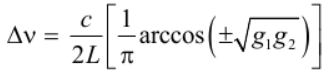 , у нас g1=g2=g = cos(2*L* $ \Delta\nu\pi$/c)

In [182]:
g = math.cos(math.pi*mean_interval_full_agr/AFD_full)

delta_g = math.sin(math.pi*mean_interval_full_agr/AFD_full)*math.pi*Delta_mean_freq_interval_full_agr/AFD_full
print(g, delta_g, delta_g/g*100)
print(round_func([delta_g]))

0.9559652885853455 0.003858508117445209 0.40362429091490326
[0.004]


g = (956 $\pm$ 4)*10^-3 , q = 0.4%

Рассчитаем значение g для режима умеренного рассогласования.

In [183]:
g = math.cos(math.pi*mean_interval_mod_agr/AFD_mod)

delta_g = math.sin(math.pi*mean_interval_mod_agr/AFD_mod)*math.pi*Delta_mean_freq_interval_mod_agr/AFD_mod
print(g, delta_g, delta_g/g*100)
print(round_func([delta_g]))

0.9754492030158786 0.0017307942575947456 0.17743561143353268
[0.002]


g = (975 $\pm$2)*10^-3 , q = 0.2%

Рассмотрим g по справочному материалу 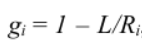
g = 0.95 
Тогда значение $\Delta\nu$ = 303247872.3127798 


In [189]:
delta_nu = c/(2*L__interf*math.pi)*math.acos(0.95)
print(delta_nu, mean_interval_full_agr)

303247872.3127798 692905083.9612191
